# Evaluate the effects of PS on P, TV, F, sEAdi etc

## Read-me
<!-- TODO ... Insert description ... -->

The code to consecutively:
<!-- TODO  Update code steps-->

## 1. Import code libraries

In [1]:
# Standard code libraries
import os
import sys
import glob
from pathlib import Path

import scipy
from scipy import interpolate as interp
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
import ipywidgets as widgets
from datetime import datetime

import neurokit2 as nk

%matplotlib widget

c:\Users\warnaarrsp\Miniconda3\envs\resurfemg_py310_dev\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Custom code libraries from the ReSurfEMG repository
# It uses the ReSurfEMG library version v0.2.1

import resurfemg.preprocessing.ecg_removal as ecg_rm
import resurfemg.preprocessing.envelope as evl
import resurfemg.preprocessing.filtering as filt
import resurfemg.postprocessing.features as feat

from resurfemg.data_connector.tmsisdk_lite import Poly5Reader

from resurfemg.config.config import Config
config = Config()

In [3]:
def moving_baseline(signal, fs, window_length):
    #  Augmented moving baseline for EMGdi signals for baseline crossing detection

    # 2.a. Calculate the "default" moving baseline over the sEAdi data over a 7.5s 
    #     window
    rolling_baseline = np.zeros((len(signal), ))
    for idx in range(0, len(signal), int(fs/5)):
        start_i = max([0, idx-int(window_length/2)])
        end_i = min([len(signal), idx+int(window_length/2)])
        baseline_value = np.nanpercentile(signal[start_i:end_i], 33)
        
        for i in range(idx, min([idx+int(fs/5), len(signal)])):
            rolling_baseline[i] = baseline_value
    
    return rolling_baseline

def augmented_moving_baseline(signal, fs, window_length, augmented_perc):
    # 2.a. Calculate the "default" moving baseline over the sEAdi data over 
    #       a 7.5s window
    default_rolling_baseline = moving_baseline(signal, fs, window_length)

    # 2.b. Rolling standard deviation and mean over 7.5s window
    baseline_series = pd.Series(default_rolling_baseline)
    baseline_std = baseline_series.rolling(window_length, 
                                    min_periods=1, 
                                    center=True).std().values
    baseline_mean = baseline_series.rolling(window_length, 
                                    min_periods=1, 
                                    center=True).mean().values

    # 2.c. Augmented signal: EMG + abs([dEMG/dt]_smoothed)
    ma_window = fs//2
    # augmented_perc = 25
    perc_window = fs

    s = pd.Series(signal - default_rolling_baseline)
    s_MA = s.rolling(window=ma_window, center=True).mean().values
    ds_dt = (s_MA[1:] - s_MA[:-1] ) * fs
    s_aug = signal[:-1] + np.abs(ds_dt)

    # 2.d. Run the moving median filter over the augmented signal to obtain the 
    #       baseline
    s_aug_rolling_baseline = np.zeros(
        (len(signal)-1, ))

    for idx in range(0, int(len(signal)-1), perc_window):
        start_i = max([0, idx-int(window_length)])
        end_i = min([len(signal)-1, idx+int(window_length)])

        baseline_value = np.nanpercentile(
            s_aug[start_i:end_i], augmented_perc)
        
        for i in range(idx, min([idx+int(perc_window), len(signal)-1])):
            s_aug_rolling_baseline[i] = 1.2 * baseline_value
    
    return s_aug_rolling_baseline, baseline_std, baseline_mean

## Initiation of output folder for experiments

In [4]:
# Input data path - The main directory where all data is loaded from
root_patient_data_directory = \
    config.get_directory('root_patient_data_directory')

# Output data - General path to dir for saving .csvs and plots
main_output_dir = os.path.join(config.get_directory('preprocessed'),
                    '2024-03_PS_exploration_QRS_detection_baseline_removal')

if not os.path.exists(main_output_dir):
    os.makedirs(main_output_dir)

patient_idx = 0

## 2. Load the ventilator and sEMG data

2.a Select a patient

In [8]:
# Select the patient of interest
# Expected data structure:
# - Patient_01
# -- Measurement_date_XXXX_XX_01
# --- 001_Baseline
# --- 002_PS_step_01
# --- 003_PS_step_02
# --- 004_PS_step_03
# --- 005_PS_step_04
# -- Measurement_date_XXXX_XX_03
# --- 001_Baseline
# --- 002_PS_step_01
# --- 003_PS_step_02
# --- 004_PS_step_03
# --- 005_PS_step_04
# -- Patient_02
# -- Measurement_date_XXXX_XX_01
# etc.

# NB Run this cell once per patient!

patient_folders = glob.glob(
        os.path.join(root_patient_data_directory, '**',''), 
        recursive=False)

patients = []
for folder in patient_folders:
    name = Path(folder).parts[-1]
    patients.append(name)

patients.sort()

btn_pt = widgets.Dropdown(  
    options=patients,
    value=patients[patient_idx],
    description='Select patient:',
    disabled=False,
)

date_idx = 0

display(btn_pt)

Dropdown(description='Select patient:', options=('MST001', 'MST002', 'MST003', 'MST004', 'MST005', 'MST006', '…

2.b Select a measurement date, or PS trial

In [9]:
# Select the PS trial of interest for the selected patient
# measurement_date ~ PEEP-trial
 
# NB Run this cell once per patient/PEEP trial combination

patient = btn_pt.value
patient_idx =btn_pt.index

measurement_folders = glob.glob(
    os.path.join(root_patient_data_directory, patient, '**',''),
    recursive=False)
measurement_dates = []

for folder in measurement_folders:
    name = Path(folder).parts[-1]
    measurement_dates.append(name)

measurement_dates.sort()

# Initialise the analysis: empty the output parameter list and start at the 
# baseline measurement (index 0)
di_data_list = []
para_data_list = []
Paw_data_list = []
Vvent_data_list =[]
ecg_data_list = []

ecg_data_all_dict = dict()
df_ecg_all_dict = dict()
channel_list = ['ecg', 'di', 'para']
columns_ecg_all = ['patient', 'measurement',
              'ecg_minmax', 'ecg_min', 'ecg_max', 'ecg_method']
for idx, channel  in enumerate(channel_list):
    ecg_data_all_dict[channel] = []
    df_ecg_all_dict[channel] = pd.DataFrame(ecg_data_all_dict[channel], columns=columns_ecg_all)

PS_step_idx = 0
plt.close('all')

btn_measurement = widgets.Dropdown(
    options=measurement_dates,
    value=measurement_dates[date_idx],
    description='Select measurement date:',
    parasabled=False,
)
display(btn_measurement)

Dropdown(description='Select measurement date:', options=('2021-12-24_09-29-46', '2021-12-27_09-16-26', '2021-…

In [85]:
# Set the default pipeline parameters
# Gating settings
gate_width_default = 0.10
gate_threshold_default = 0.30
gate_ECG_shift_default = -10
gate_twice = False

# RMS window
RMS_window_ms_default = 200

# Peak detection settings
time_shift_default = 0.5 - RMS_window_ms_default/1000/2
sEAdi_prominence_factor_default = 0.5
sEApara_prominence_factor_default = 0.5

2.c Select a PS step

In [86]:
# Select the PS step of interest for the selected patient/measurement_date

# NB Re-run this cell for each new PEEP trial, as it also empties output 
# parameter list (di_data_list)!


# Create output data folders
measurement_date = btn_measurement.value
date_idx = btn_measurement.index

output_path = os.path.join(main_output_dir, patient, measurement_date)
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Identify all PS step folders:
root_emg_directory = os.path.join(
    root_patient_data_directory, patient, measurement_date)

emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_vent_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
vent_files = []
plt.close('all')

for file in emg_and_vent_files:
    if 'Draeger' in file:
        vent_files.append(file)
    else:
        emg_files.append(file)

emg_files.sort()
vent_files.sort()

list_of_numbers_string = []

for i in range(len(emg_files)):
    list_of_numbers_string.append(Path(emg_files[i]).parts[-2])

# Select the PEEP step of interest. The selection menu initialises at the third 
# but last (index -4) recording. The PEEP steps are named after the folders 
# containing the data files (.poly5) of interest.

btn_PS_step = widgets.Dropdown(
    options=list_of_numbers_string,
    value= list_of_numbers_string[PS_step_idx],
    description='Picked File:',
    disabled=False,
)
display(btn_PS_step)

Dropdown(description='Picked File:', index=2, options=('001', '002', '003', '004', '005', '007', '008', '006 -…

In [87]:
# Process selected option: the PEEP step of interest  
PS_step_chosen = btn_PS_step.value
PS_step_idx = int(btn_PS_step.index)
emg_file_chosen = emg_files[PS_step_idx]
vent_file_chosen = vent_files[PS_step_idx]
print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

The chosen files are:
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW\MST001\2021-12-27_09-16-26\002\EMG_recording.Poly5 
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW\MST001\2021-12-27_09-16-26\002\Draeger_recording.Poly5


In [88]:
# Load the EMG and ventilator data recordings from the selected folders.
data_emg = Poly5Reader(emg_file_chosen)
data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
data_vent_samples = data_vent.samples[:data_vent.num_samples]
fs_vent = data_vent.sample_rate

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples
# y_emg = data_emg_samples[:, :350*2048]
# Reshufle the channels if necessary
# y_emg = np.array([-data_emg_samples[0, :], 
#                    data_emg_samples[1, :], 
#                    data_emg_samples[2, :]])
# # Reshufle the channels if necessary
# y_emg = np.array([-data_emg_samples[2, :], 
#                    data_emg_samples[0, :], 
#                    -data_emg_samples[1, :]])
y_vent = data_vent_samples

# Define the time axes
t_emg = np.array([i/fs_emg for i in range(len(y_emg[0, :]))])
t_vent = np.array([i/fs_vent for i in range(len(y_vent[0, :]))])

# Default settings for window of interest
# manoeuvres (Pocc)
# t_start_default = t_vent[-1]-61
# t_end_default = t_vent[-1]-1
t_start_default = t_vent[0]
t_end_default = t_vent[-1]

del data_emg_samples, data_vent_samples, data_emg, data_vent

btn_plt_raw = widgets.Dropdown(
    options=['Yes', 'No'],
    value='No',
    description='Plot raw data?',
    parasabled=False,
)
display(btn_plt_raw)

Reading file  P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW\MST001\2021-12-27_09-16-26\002\EMG_recording.Poly5
	 Number of samples:  1121616 
	 Number of channels:  3 
	 Sample rate: 2048 Hz


Done reading data.
Reading file  P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW\MST001\2021-12-27_09-16-26\002\Draeger_recording.Poly5
	 Number of samples:  54760 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


Dropdown(description='Plot raw data?', index=1, options=('Yes', 'No'), value='No')

In [89]:
# Plot the raw data if wanted
if btn_plt_raw.value == 'Yes':
 
    fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)

    axis[0, 0].grid(True)
    axis[0, 0].plot(t_emg, y_emg[0])
    axis[0, 0].set(title='sEMG leads')
    axis[0, 0].set_ylabel('ECG (uV)')

    axis[1, 0].grid(True)
    axis[1, 0].plot(t_emg, y_emg[1])
    axis[1, 0].set_ylabel('sEMGdi (uV)')
    axis[1, 0].set_xlabel('t (s)')

    axis[2, 0].grid(True)
    axis[2, 0].plot(t_emg, y_emg[2])
    axis[2, 0].set_ylabel('sEMGpara (uV)')
    axis[2, 0].set_xlabel('t (s)')

    axis[0, 1].set(title='Ventilator data')
    axis[0, 1].grid(True)
    axis[0, 1].plot(t_vent, y_vent[0])
    axis[0, 1].set_ylabel('Paw (cmH2O)')

    axis[1, 1].grid(True)
    axis[1, 1].plot(t_vent, y_vent[1])
    axis[1, 1].set_ylabel('F (L/min)')

    axis[2, 1].grid(True)
    axis[2, 1].plot(t_vent, y_vent[2])
    axis[2, 1].set_ylabel('V (mL)')
    axis[2, 1].set_xlabel('t (s)')

## 3. Select the time window of interest

In [90]:
start = t_start_default
end = t_end_default

start_s = int(float(start)* fs_emg)
end_s = min([int(float(end)*fs_emg), len(y_emg[0,:])-1])
start_vent_s = int(float(start)* fs_vent)
end_vent_s = min(
    [int(float(end)* fs_vent), len(y_vent[0,:])-1]
)

fig_w = (int(end_vent_s)-int(start_vent_s))//(fs_vent*80)*12

## 4.a. ECG properties extraction

In [91]:
# Filter raw EMG signals according to AHA 1990 guidelines
y_emg_ECG_filt_AHA = filt.emg_bandpass_butter_sample(y_emg, 0.05, 150, fs_emg)

y_emg_ECG_filt = filt.emg_bandpass_butter_sample(y_emg, 1, 80, fs_emg)
# y_emg_ECG_filt = y_emg

# # See https://ieeexplore.ieee.org/document/10290007 for performance
# ecg_method = 'Zong'      # 'neurokit', 'hamilton2002', 'pantompkins1985', 'engzeemod2012'

ecg_dicts = dict()
channel_list = ['ecg', 'di', 'para']
for idx, channel in enumerate(channel_list):
    ecg_dicts[channel] = dict()

# RMS and peak detection settings
RMS_window_ecg_ms = 50
RMS_windows_samp = int(RMS_window_ecg_ms / 1000 *  fs_emg)
distance = fs_emg//10

# Moving baseline parameters
w_moving_baseline = 5 * fs_emg

# ecg_type = 'raw'    # 'clean'
channel = 'ecg'
channel_list = ['ecg', 'di', 'para']

T_ecg_bin_w = 0.1

for idx, channel in enumerate(channel_list):
    y_emg_ECG_filt[idx, :]
    ecg_dicts[channel]['raw'] = y_emg[idx, :]
    ecg_dicts[channel]['filt'] = y_emg_ECG_filt[idx, :]
    ecg_dicts[channel]['filt_AHA'] = y_emg_ECG_filt_AHA[idx, :]
    
    pre_samp = int(np.ceil(RMS_windows_samp/2))
    post_samp = int(np.floor(RMS_windows_samp/2))
    padding_pre = np.zeros((pre_samp,))
    padding_end = np.zeros((post_samp,))
    ecg_dicts[channel]['filt_padded'] = np.concatenate(
         (padding_pre, ecg_dicts[channel]['filt'], padding_end))

    # sEAdi_padded = evl.full_rolling_rms(emg_di_gated_padded, RMS_windows_samp)
    # sEAdi = sEAdi_padded[:-RMS_windows_samp]

    ecg_dicts[channel]['rms'] = evl.full_rolling_rms(
        ecg_dicts[channel]['filt_padded'], 
        RMS_windows_samp)
    
    ecg_dicts[channel]['rms'] = ecg_dicts[channel]['rms'][:-RMS_windows_samp]
    
    prominence = 0.01*(np.percentile(ecg_dicts[channel]['rms'], 95) 
                  - min(ecg_dicts[channel]['rms']))
    
    peaks, _ = scipy.signal.find_peaks(ecg_dicts[channel]['rms'], 
                                       prominence=prominence,
                                       distance=distance)
    # ecg_dicts[channel]['peaks'] = np.array(peaks)
    ecg_dicts[channel]['peak_df'] = pd.DataFrame({"peak_idx":np.array(peaks)})
    ecg_dicts[channel]['method'] = 'custom'
    
    ecg_dicts[channel]['mb_rms'] = moving_baseline(ecg_dicts[channel]['rms'], fs_emg, w_moving_baseline)
    ecg_dicts[channel]['mb_filt'] = moving_baseline(ecg_dicts[channel]['filt'], fs_emg, w_moving_baseline)

    # scipy.signal.argrelextrema(ecg_dicts[channel]['d_dt_mb_rms'])

len(ecg_dicts['ecg']['peak_df']), len(ecg_dicts['di']['peak_df']), len(ecg_dicts['para']['peak_df'])

(2367, 2940, 3682)

In [93]:
slope_window = 20   # 1/slope_window
slope_order = fs_emg//slope_window
for idx, channel in enumerate(channel_list):
    # print(channel)
    peak_df = ecg_dicts[channel]['peak_df']
    ecg_dicts[channel]['d_dt_rms'] = (ecg_dicts[channel]['rms'][1:] - ecg_dicts[channel]['rms'][:-1])*fs_emg
    peak_idx_list  = peak_df["peak_idx"].values
    
    local_extremes_vec_up = scipy.signal.argrelextrema(
        ecg_dicts[channel]['d_dt_rms'], np.greater, order=slope_order)[0]
    idxs_mat_up = (np.matlib.repmat(local_extremes_vec_up, len(peak_idx_list), 1) 
                - np.matlib.repmat(peak_idx_list, len(local_extremes_vec_up), 1).T)

    loc_crossings_up = np.argwhere(np.diff(np.sign(idxs_mat_up)) != 0)
    loc_crossings_up = loc_crossings_up[:, 1]

    local_extremes_vec_down = scipy.signal.argrelextrema(
        ecg_dicts[channel]['d_dt_rms'], np.less, order=slope_order)[0]
    idxs_mat_down = (np.matlib.repmat(local_extremes_vec_down, len(peak_idx_list), 1) 
                - np.matlib.repmat(peak_idx_list, len(local_extremes_vec_down), 1).T)

    loc_crossings_down = np.argwhere(np.diff(np.sign(idxs_mat_down)) != 0)
    loc_crossings_down = loc_crossings_down[:, 1] + 1

    peak_upslope_idx = local_extremes_vec_up[loc_crossings_up]
    peak_downslope_idx = local_extremes_vec_down[loc_crossings_down]

    len_starts = len(peak_upslope_idx)
    len_ends = len(peak_downslope_idx)
    len_pks = len(peak_idx_list)
    min_len = min([len_starts, len_pks, len_ends])
    
    # Align starts and ends
    perc_start_bf_prev_end = np.sum((peak_upslope_idx[1:min_len]<
                            peak_downslope_idx[0:min_len-1]))/(min_len-1)
    if (perc_start_bf_prev_end > 0.5):
        # Start misaligned with ends (first start missing)
        peak_upslope_idx = peak_upslope_idx[1:] 

    if len(peak_upslope_idx) != len(peak_downslope_idx):
        if peak_upslope_idx[-1] > peak_downslope_idx[-1]:
            # Last detected upslope after last detected downslope 
            peak_upslope_idx = peak_upslope_idx[:-1]

        if ((peak_upslope_idx[-1] < peak_downslope_idx[-1])
            & (peak_upslope_idx[-1] < peak_downslope_idx[-2])):
            # Two downslopes after last detected upslope
            peak_downslope_idx = peak_downslope_idx[:-1]
    
    if len(peak_upslope_idx) != len(peak_downslope_idx):
        print('Error: Up- and downslope arrays not of equal length!')
        len_starts = len(peak_upslope_idx)
        len_ends = len(peak_downslope_idx)
        len_pks = len(peak_idx_list)
        min_len = min([len_starts, len_pks, len_ends])
        print(len_starts, len_pks, len_ends)
    
    if ((len(peak_upslope_idx) < len(peak_idx_list))
        | (len(peak_downslope_idx) < len(peak_idx_list))):
        peak_idx_bf_start = np.nonzero(
            peak_idx_list < peak_upslope_idx[0])[0].tolist()
        peak_idx_after_end = np.nonzero(
            peak_idx_list > peak_downslope_idx[-1])[0].tolist()
        
        delete_idx = peak_idx_bf_start + peak_idx_after_end

        peak_df = peak_df.drop(delete_idx).reset_index(drop=True)
        peak_idx_list = peak_df["peak_idx"].values

    if ((len(peak_upslope_idx) < len(peak_idx_list))
        | (len(peak_downslope_idx) < len(peak_idx_list))):
        print('Error: Peak array not of equal length with up- and downslope '
              +'arrays!')
        len_starts = len(peak_upslope_idx)
        len_ends = len(peak_downslope_idx)
        len_pks = len(peak_idx_list)
        min_len = min([len_starts, len_pks, len_ends])
        print(len_starts, len_pks, len_ends)

    peak_df['peak_upslope_idx'] = peak_upslope_idx
    peak_df['peak_upslope_val'] = \
        ecg_dicts[channel]['d_dt_rms'][peak_upslope_idx]

    peak_df['peak_downslope_idx'] = peak_downslope_idx
    peak_df['peak_downslope_val'] = \
        ecg_dicts[channel]['d_dt_rms'][peak_downslope_idx]
    
    ecg_dicts[channel]['peak_df'] = peak_df

In [94]:
for idx, channel in enumerate(channel_list):   
    peak_df = ecg_dicts[channel]['peak_df']
    y_vals = ecg_dicts[channel]['rms'][peak_df['peak_upslope_idx'].values]
    dy_dt_vals = peak_df['peak_upslope_val'].values

    peak_df['peak_upslope_idx_ds'] = np.array(
        y_vals * fs_emg // (dy_dt_vals), dtype=int).astype(np.int64)

    peak_df['peak_upslope_start_s'] = \
        peak_df['peak_upslope_idx'] - peak_df['peak_upslope_idx_ds']
    peak_df.loc[peak_df['peak_upslope_start_s'] < 0, 'peak_upslope_start_s'] = 0
    
    y_vals = ecg_dicts[channel]['rms'][peak_df['peak_downslope_idx'].values]
    dy_dt_vals = peak_df['peak_downslope_val'].values

    peak_df['peak_downslope_idx_ds'] = np.array(
        y_vals * fs_emg // (dy_dt_vals), dtype=int).astype(np.int64)
    
    peak_df['peak_downslope_end_s'] = \
        peak_df['peak_downslope_idx'] - peak_df['peak_downslope_idx_ds']
    
    peak_df.loc[
        peak_df['peak_downslope_end_s'] >= len(ecg_dicts[channel]['rms']), 
        'peak_downslope_end_s'] = len(ecg_dicts[channel]['rms']) - 1
    
    ecg_dicts[channel]['peak_df'] = peak_df 


bin_edges[1:], hist

Text(0.5, 0, 't (s)')

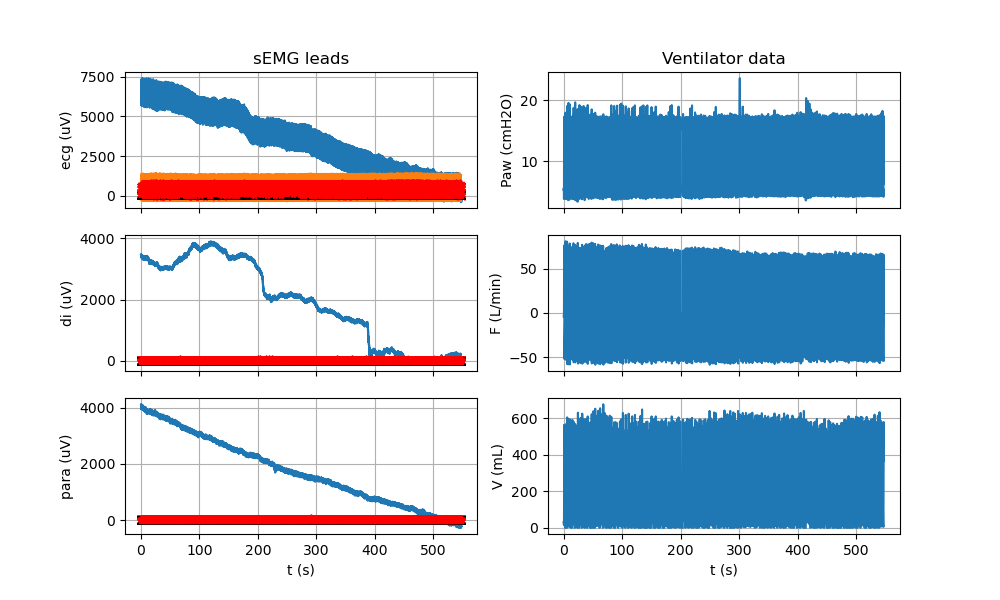

In [95]:
fig_t, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
for idx, channel in enumerate(channel_list):
    peak_df = ecg_dicts[channel]['peak_df']

    axis[idx, 0].grid(True)
    axis[idx, 0].plot(t_emg, ecg_dicts[channel]['raw'] - np.percentile(ecg_dicts[channel]['raw'], 5))
    axis[idx, 0].plot(t_emg, ecg_dicts[channel]['filt'])
    axis[idx, 0].plot(t_emg, ecg_dicts[channel]['mb_filt'])
    axis[idx, 0].plot(t_emg, ecg_dicts[channel]['mb_rms'])
    axis[idx, 0].plot(t_emg, ecg_dicts[channel]['rms'])
    axis[idx, 0].plot(t_emg[peak_df['peak_upslope_idx'].values], 
                      ecg_dicts[channel]['rms'][
                          peak_df['peak_upslope_idx'].values], 'rx')
    axis[idx, 0].plot(t_emg[peak_df['peak_downslope_idx'].values], 
                      ecg_dicts[channel]['rms'][
                          peak_df['peak_downslope_idx'].values], 'rx')

    axis[idx, 0].plot(t_emg[peak_df['peak_upslope_start_s'].values], 
                      ecg_dicts[channel]['mb_rms'][
                          peak_df['peak_upslope_start_s'].values], 'mx')
    axis[idx, 0].plot(t_emg[peak_df['peak_downslope_end_s'].values], 
                      ecg_dicts[channel]['mb_rms'][
                          peak_df['peak_downslope_end_s'].values], 'kx')

    axis[idx, 0].plot(t_emg[peak_df['peak_idx']], 
                      ecg_dicts[channel]['rms'][peak_df['peak_idx']], '*r')
    
    axis[idx, 0].set_ylabel(channel_list[idx] + ' (uV)')
axis[idx, 0].set_xlabel('t (s)')

axis[0, 0].set(title='sEMG leads')
axis[2, 0].set_xlabel('t (s)')

axis[0, 1].set(title='Ventilator data')
axis[0, 1].grid(True)
axis[0, 1].plot(t_vent, y_vent[0])
axis[0, 1].set_ylabel('Paw (cmH2O)')

axis[1, 1].grid(True)
axis[1, 1].plot(t_vent, y_vent[1])
axis[1, 1].set_ylabel('F (L/min)')

axis[2, 1].grid(True)
axis[2, 1].plot(t_vent, y_vent[2])
axis[2, 1].set_ylabel('V (mL)')
axis[2, 1].set_xlabel('t (s)')

Text(0, 0.5, 'Bin count (.)')

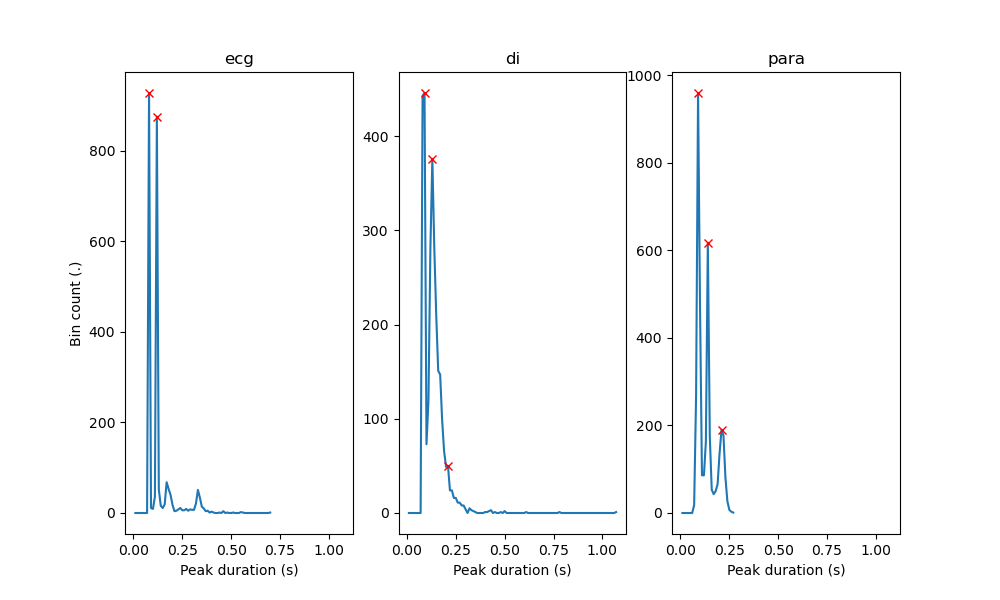

In [97]:
fig_hist_ecg, axis = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), sharex=True)
bin_w = 0.01

channel_list = ['ecg', 'di', 'para']

for idx, channel  in enumerate(channel_list):
    peak_df = ecg_dicts[channel]['peak_df']
    d_peaks = (peak_df['peak_downslope_end_s'].values
               - peak_df['peak_upslope_start_s'].values)/fs_emg

    hist, bin_edges = np.histogram(d_peaks, bins=[x*bin_w for x in 
                      range(int(max(d_peaks)/bin_w)+2)])
    bin_edges = bin_edges[1:]
    pks, _ = scipy.signal.find_peaks(hist, height=max(hist)/10)

    axis[idx].plot(bin_edges,hist)
    axis[idx].plot(bin_edges[pks],hist[pks], 'rx')
    axis[idx].set_title(channel)
    axis[idx].set_xlabel('Peak duration (s)')

    ecg_dicts[channel]['qrs_duration'] = bin_edges[pks[0]]
    d_thres = 0.25 * bin_edges[pks[0]] + bin_edges[pks[0]]
    peak_df['included'] = (d_peaks <= d_thres)

    ecg_dicts[channel]['peak_df'] = peak_df

axis[0].set_ylabel('Bin count (.)')

In [98]:
for idx, channel in enumerate(channel_list):
    print(ecg_dicts[channel]['qrs_duration'])
    

0.08
0.09
0.09


Text(0.5, 0, 't (s)')

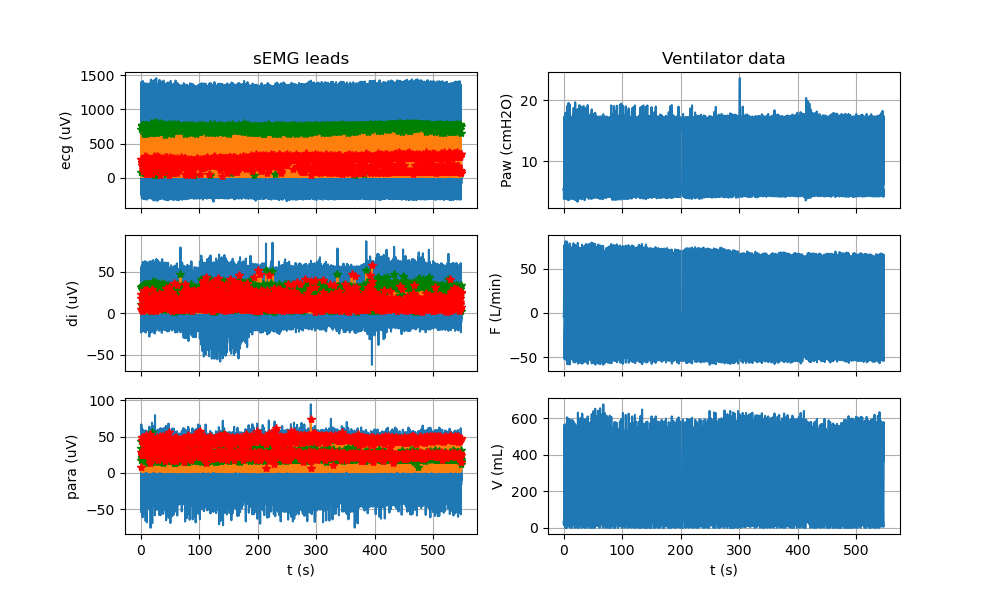

In [99]:
fig_t, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
for idx, channel in enumerate(channel_list):
    axis[idx, 0].grid(True)
    # axis[idx, 0].plot(t_emg, ecg_dicts[channel]['raw'] - np.percentile(ecg_dicts[channel]['raw'], 5))
    peak_df = ecg_dicts[channel]['peak_df']
    incl_pks = (peak_df['included'] == True)
    excl_pks = (peak_df['included'] == False)
    axis[idx, 0].plot(t_emg, ecg_dicts[channel]['filt'])
    axis[idx, 0].plot(t_emg, ecg_dicts[channel]['rms'])


    axis[idx, 0].plot(t_emg[peak_df.loc[incl_pks, 'peak_idx'].values], 
                      ecg_dicts[channel]['rms'][peak_df.loc[incl_pks, 'peak_idx'].values], '*g')
    axis[idx, 0].plot(t_emg[peak_df.loc[excl_pks, 'peak_idx'].values], 
                      ecg_dicts[channel]['rms'][peak_df.loc[excl_pks, 'peak_idx'].values], '*r')
    
    axis[idx, 0].set_ylabel(channel_list[idx] + ' (uV)')
axis[idx, 0].set_xlabel('t (s)')

axis[0, 0].set(title='sEMG leads')
axis[2, 0].set_xlabel('t (s)')

axis[0, 1].set(title='Ventilator data')
axis[0, 1].grid(True)
axis[0, 1].plot(t_vent, y_vent[0])
axis[0, 1].set_ylabel('Paw (cmH2O)')

axis[1, 1].grid(True)
axis[1, 1].plot(t_vent, y_vent[1])
axis[1, 1].set_ylabel('F (L/min)')

axis[2, 1].grid(True)
axis[2, 1].plot(t_vent, y_vent[2])
axis[2, 1].set_ylabel('V (mL)')
axis[2, 1].set_xlabel('t (s)')

In [100]:
# Drop excluded peaks
for idx, channel in enumerate(channel_list):
    peak_df = ecg_dicts[channel]['peak_df']
    
    excl_pks_idx = peak_df.index[peak_df['included'].values == False].values
    # print(excl_pks_idx)
    peak_df = peak_df.drop(excl_pks_idx).reset_index(drop=True)

    ecg_dicts[channel]['peak_df'] = peak_df


Text(0.5, 0, 't (s)')

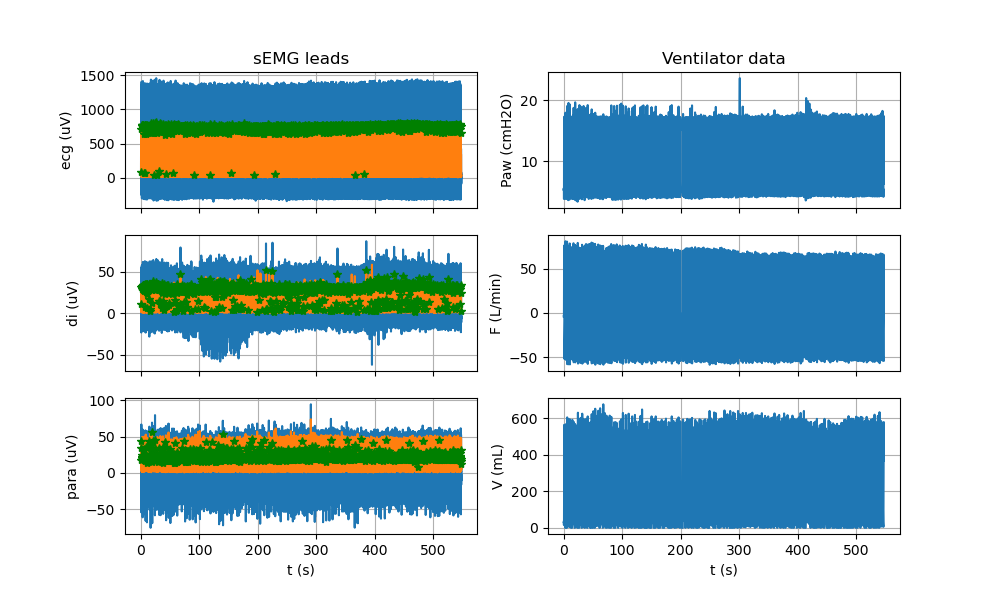

In [101]:
fig_t, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
for idx, channel in enumerate(channel_list):
    axis[idx, 0].grid(True)
    # axis[idx, 0].plot(t_emg, ecg_dicts[channel]['raw'] - np.percentile(ecg_dicts[channel]['raw'], 5))
    peak_df = ecg_dicts[channel]['peak_df']
    incl_pks = (peak_df['included'] == True)
    excl_pks = (peak_df['included'] == False)
    axis[idx, 0].plot(t_emg, ecg_dicts[channel]['filt'])
    axis[idx, 0].plot(t_emg, ecg_dicts[channel]['rms'])


    axis[idx, 0].plot(t_emg[peak_df.loc[incl_pks, 'peak_idx'].values], 
                      ecg_dicts[channel]['rms'][peak_df.loc[incl_pks, 'peak_idx'].values], '*g')
    axis[idx, 0].plot(t_emg[peak_df.loc[excl_pks, 'peak_idx'].values], 
                      ecg_dicts[channel]['rms'][peak_df.loc[excl_pks, 'peak_idx'].values], '*r')
    
    axis[idx, 0].set_ylabel(channel_list[idx] + ' (uV)')
axis[idx, 0].set_xlabel('t (s)')

axis[0, 0].set(title='sEMG leads')
axis[2, 0].set_xlabel('t (s)')

axis[0, 1].set(title='Ventilator data')
axis[0, 1].grid(True)
axis[0, 1].plot(t_vent, y_vent[0])
axis[0, 1].set_ylabel('Paw (cmH2O)')

axis[1, 1].grid(True)
axis[1, 1].plot(t_vent, y_vent[1])
axis[1, 1].set_ylabel('F (L/min)')

axis[2, 1].grid(True)
axis[2, 1].plot(t_vent, y_vent[2])
axis[2, 1].set_ylabel('V (mL)')
axis[2, 1].set_xlabel('t (s)')

ecg
[0.25 0.35 0.6 ]
di
[0.15 0.25 0.4  0.6 ]
para
[0.15 0.25 0.35 0.6 ]


Text(0, 0.5, 'Bin count (.)')

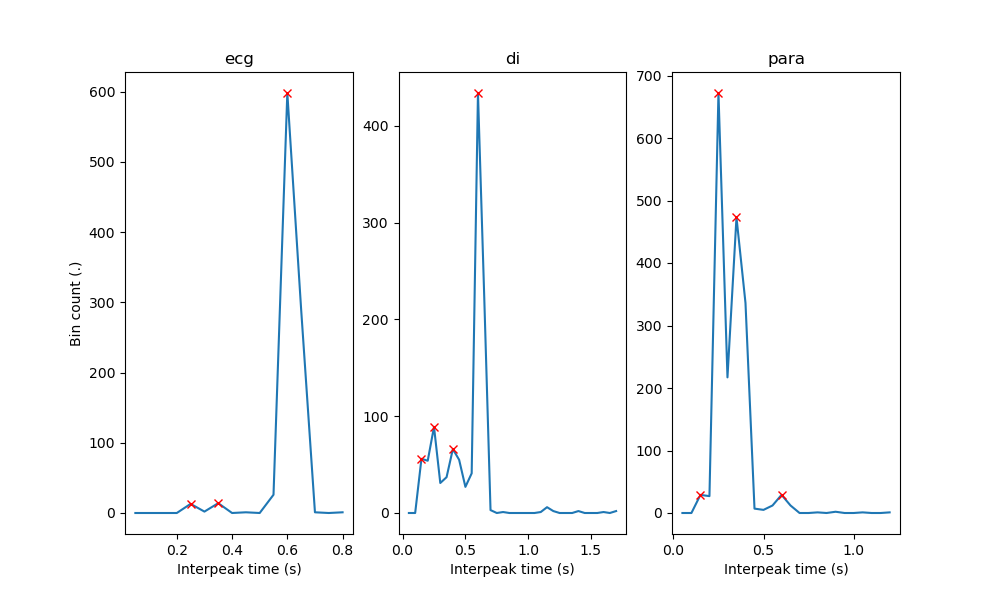

In [104]:
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
bin_w = 0.05

channel_list = ['ecg', 'di', 'para']

for idx, channel  in enumerate(channel_list):
    peak_df = ecg_dicts[channel]['peak_df']
    
    T_peaks = (peak_df['peak_idx'].values[1:]
               - peak_df['peak_idx'].values[:-1])/fs_emg

    hist, bin_edges = np.histogram(T_peaks, bins=[x*bin_w for x in 
                      range(int(max(T_peaks)/bin_w)+2)])
    bin_edges = bin_edges[1:]
    pks, _ = scipy.signal.find_peaks(hist, height=max(hist)/50)

    axis[idx].plot(bin_edges,hist)
    axis[idx].plot(bin_edges[pks],hist[pks], 'rx')
    axis[idx].set_title(channel)
    axis[idx].set_xlabel('Interpeak time (s)')

    ecg_dicts[channel]['T_interpeak'] = bin_edges[pks]
    ecg_dicts[channel]['T_interpeak_counts'] = hist[pks]

    print(channel)
    print(ecg_dicts[channel]['T_interpeak'])


axis[0].set_ylabel('Bin count (.)')

Text(0, 0.5, 'Peak amp (uV)')

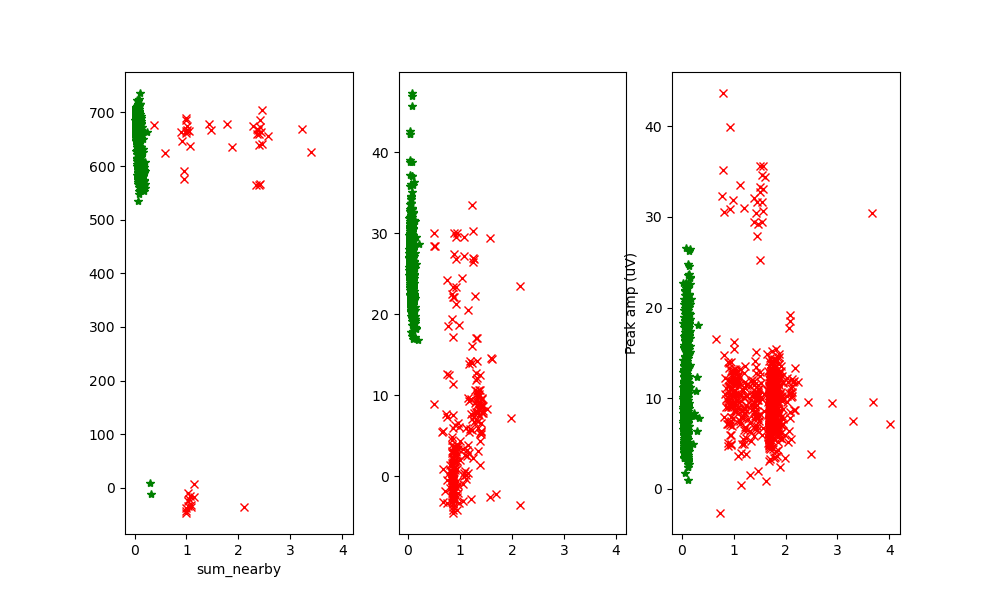

In [211]:

channel_list = ['ecg', 'di', 'para']


ecg_peaks = ecg_dicts['ecg']['peak_df']['peak_idx']
di_peaks = ecg_dicts['di']['peak_df']['peak_idx']
para_peaks = ecg_dicts['para']['peak_df']['peak_idx']


for idx, channel  in enumerate(channel_list):
    peak_df = ecg_dicts[channel]['peak_df']
    channel_peaks = peak_df['peak_idx'].values
    ecg_nearby = np.abs(np.matlib.repmat(channel_peaks, len(ecg_peaks), 1) 
                - np.matlib.repmat(ecg_peaks, len(channel_peaks), 1).T)
    loc_ecg_idx = np.argmin(ecg_nearby, axis=0)
    loc_ecg = ecg_peaks[loc_ecg_idx]

    di_nearby = np.abs(np.matlib.repmat(channel_peaks, len(di_peaks), 1) 
                - np.matlib.repmat(di_peaks, len(channel_peaks), 1).T)
    loc_di_idx = np.argmin(di_nearby, axis=0)
    loc_di = di_peaks[loc_di_idx]

    para_nearby = np.abs(np.matlib.repmat(channel_peaks, len(para_peaks), 1) 
                - np.matlib.repmat(para_peaks, len(channel_peaks), 1).T)
    loc_para_idx = np.argmin(para_nearby, axis=0)
    loc_para = para_peaks[loc_para_idx]

    sum_nearby = (np.array(abs(loc_ecg-channel_peaks)) 
                  + np.array(abs(loc_di-channel_peaks))
                  + np.array(abs(loc_para-channel_peaks)))
    
    peak_df['sum_nearby'] = sum_nearby/fs_emg/3
    peak_df['included'] = (peak_df['sum_nearby'].values <=
                           ecg_dicts[channel]['qrs_duration']/3)

    ecg_dicts[channel]['peak_df'] = peak_df

fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), sharex=True)
for idx, channel  in enumerate(channel_list):
    peak_df = ecg_dicts[channel]['peak_df']
    rms_t = ecg_dicts[channel]['rms'] - ecg_dicts[channel]['mb_rms']
    
    sum_nearby = (peak_df['sum_nearby'].values / 
                  ecg_dicts[channel]['qrs_duration'])
    
    peak_amp = rms_t[peak_df['peak_idx'].values]

    axis[idx].plot(sum_nearby[sum_nearby > 1/3],
                   peak_amp[sum_nearby > 1/3], 'rx')
    axis[idx].plot(sum_nearby[sum_nearby <= 1/3],
                   peak_amp[sum_nearby <= 1/3], 'g*')
    axis[0].set_xlabel('sum_nearby')

axis[idx].set_ylabel('Peak amp (uV)')

Text(0.5, 0, 't (s)')

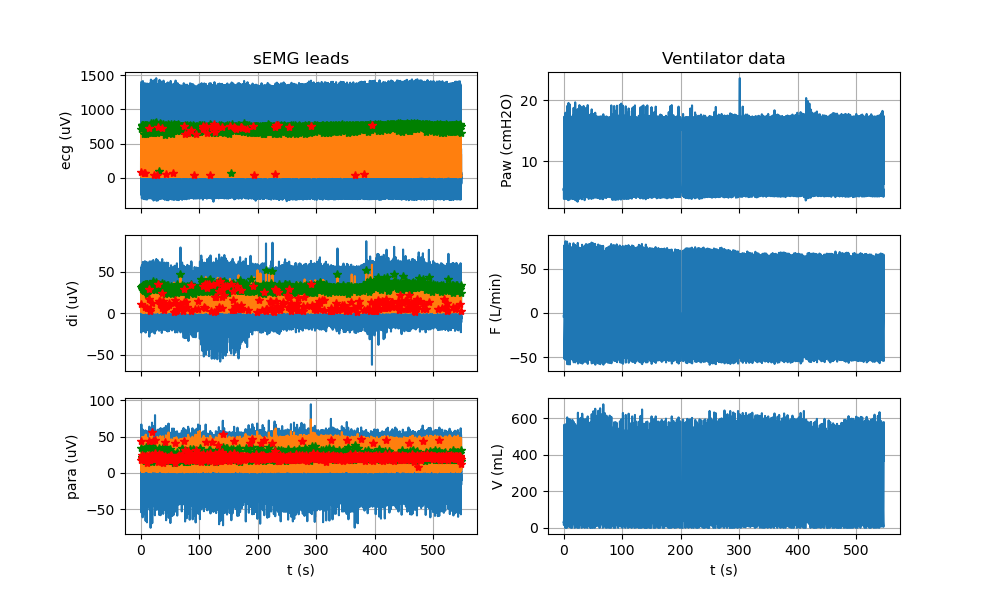

In [201]:
channel_list = ['ecg', 'di', 'para']
fig_t, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)

for idx, channel  in enumerate(channel_list):
    peak_df = ecg_dicts[channel]['peak_df']
    peak_df['included'] = (peak_df['sum_nearby'].values <=
                           ecg_dicts[channel]['qrs_duration']/3)

    ecg_dicts[channel]['peak_df'] = peak_df


    axis[idx, 0].grid(True)
    incl_pks = (peak_df['included'] == True)
    excl_pks = (peak_df['included'] == False)
    axis[idx, 0].plot(t_emg, ecg_dicts[channel]['filt'])
    axis[idx, 0].plot(t_emg, ecg_dicts[channel]['rms'])


    axis[idx, 0].plot(t_emg[peak_df.loc[incl_pks, 'peak_idx'].values], 
                      ecg_dicts[channel]['rms'][peak_df.loc[incl_pks, 'peak_idx'].values], '*g')
    axis[idx, 0].plot(t_emg[peak_df.loc[excl_pks, 'peak_idx'].values], 
                      ecg_dicts[channel]['rms'][peak_df.loc[excl_pks, 'peak_idx'].values], '*r')
    
    axis[idx, 0].set_ylabel(channel_list[idx] + ' (uV)')
axis[idx, 0].set_xlabel('t (s)')

axis[0, 0].set(title='sEMG leads')
axis[2, 0].set_xlabel('t (s)')

axis[0, 1].set(title='Ventilator data')
axis[0, 1].grid(True)
axis[0, 1].plot(t_vent, y_vent[0])
axis[0, 1].set_ylabel('Paw (cmH2O)')

axis[1, 1].grid(True)
axis[1, 1].plot(t_vent, y_vent[1])
axis[1, 1].set_ylabel('F (L/min)')

axis[2, 1].grid(True)
axis[2, 1].plot(t_vent, y_vent[2])
axis[2, 1].set_ylabel('V (mL)')
axis[2, 1].set_xlabel('t (s)')

ecg
[0.6  1.15]
di
[0.6  1.15]
para
[0.6  1.15]


Text(0, 0.5, 'Bin count (.)')

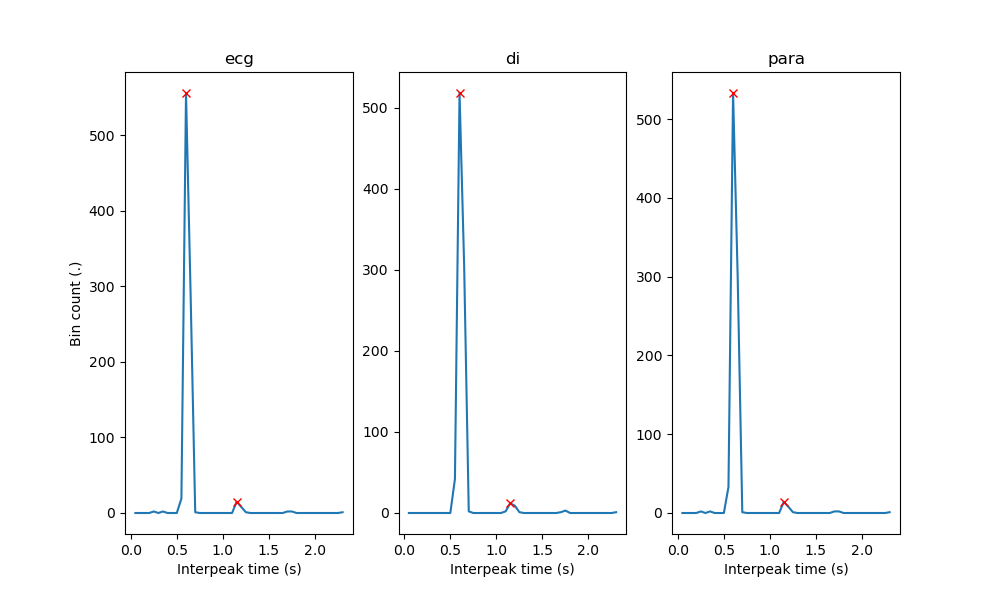

In [213]:
# Drop excluded peaks
for idx, channel in enumerate(channel_list):
    peak_df = ecg_dicts[channel]['peak_df']
    
    excl_pks_idx = peak_df.index[peak_df['included'].values == False].values
    peak_df = peak_df.drop(excl_pks_idx).reset_index(drop=True)

    ecg_dicts[channel]['peak_df'] = peak_df

fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
bin_w = 0.05

channel_list = ['ecg', 'di', 'para']

for idx, channel  in enumerate(channel_list):
    peak_df = ecg_dicts[channel]['peak_df']
    
    T_peaks = (peak_df['peak_idx'].values[1:]
               - peak_df['peak_idx'].values[:-1])/fs_emg

    hist, bin_edges = np.histogram(T_peaks, bins=[x*bin_w for x in 
                      range(int(max(T_peaks)/bin_w)+2)])
    bin_edges = bin_edges[1:]
    pks, _ = scipy.signal.find_peaks(hist, height=max(hist)/50)

    axis[idx].plot(bin_edges,hist)
    axis[idx].plot(bin_edges[pks],hist[pks], 'rx')
    axis[idx].set_title(channel)
    axis[idx].set_xlabel('Interpeak time (s)')

    ecg_dicts[channel]['T_interpeak'] = bin_edges[pks]
    ecg_dicts[channel]['T_interpeak_counts'] = hist[pks]

    print(channel)
    print(ecg_dicts[channel]['T_interpeak'])


axis[0].set_ylabel('Bin count (.)')


In [218]:
# Min-Max amplitude
channel_list = ['ecg', 'di', 'para']

for idx, channel  in enumerate(channel_list):
    peak_df = ecg_dicts[channel]['peak_df']
    peaks_list = peak_df['peak_idx'].values
    starts_list = peak_df['peak_upslope_start_s'].values
    ends_list = peak_df['peak_downslope_end_s'].values

    min_vals = []
    min_idxs = []
    max_vals = []
    max_idxs = []
    minmax = []
    auc = []

    
    for pk_nr, pk_idx  in enumerate(peaks_list):
        _s_start = starts_list[pk_nr]
        _s_end = ends_list[pk_nr]
        # _signal = ecg_dicts[channel]['filt_AHA'][_s_start:_s_end]
        _signal = ecg_dicts[channel]['filt'][_s_start:_s_end] - baseline!!

        min_vals.append(np.min(_signal))
        min_idxs.append(
            np.argmin(_signal) + _s_start)
        max_vals.append(np.max(_signal))
        max_idxs.append(
            np.argmax(_signal) + _s_start)
        minmax.append(np.max(_signal) - np.min(_signal))
        auc.append(np.trapz(np.abs(_signal),dx=1/fs_emg)
    )
    peak_df['min_vals'] = min_vals
    peak_df['min_idxs'] = min_idxs
    peak_df['max_vals'] = max_vals
    peak_df['max_idxs'] = max_idxs
    peak_df['minmax'] = minmax
    peak_df['auc'] = auc

    ecg_dicts[channel]['peak_df'] = peak_df


SyntaxError: invalid syntax (800856831.py, line 22)

Text(0.5, 0, 't (s)')

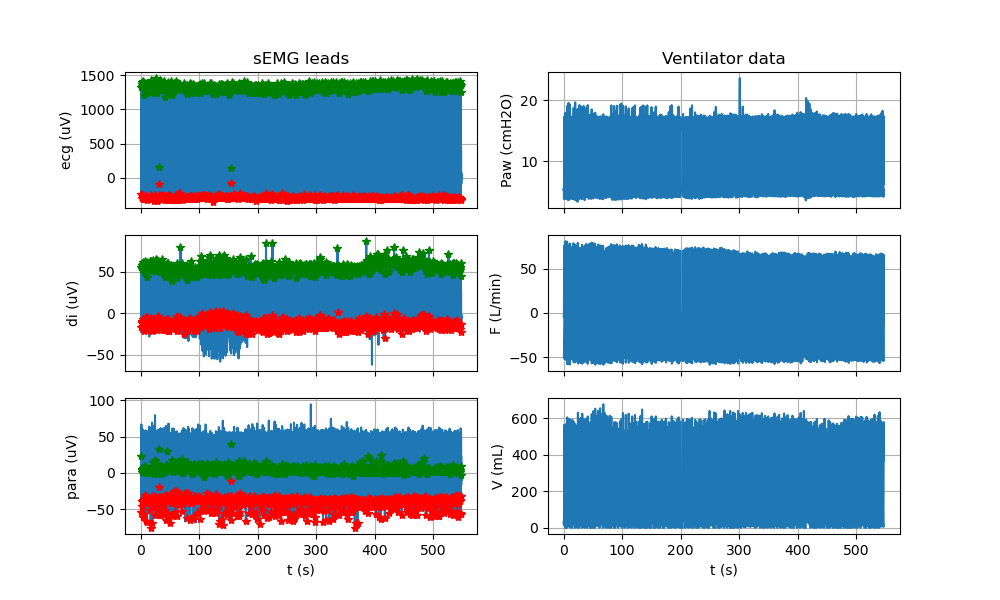

In [217]:
fig_t, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)

for idx, channel in enumerate(channel_list):
    peak_df = ecg_dicts[channel]['peak_df']
    min_vals = peak_df['min_vals']
    min_idxs = peak_df['min_idxs']
    max_vals = peak_df['max_vals']
    max_idxs = peak_df['max_idxs']
    minmax = peak_df['minmax']
    auc = peak_df['auc']

    axis[idx, 0].grid(True)
    # axis[idx, 0].plot(t_emg, ecg_dicts[channel]['filt_AHA'])
    # axis[idx, 0].plot(t_emg[min_idxs], 
    #                   ecg_dicts[channel]['filt_AHA'][min_idxs], '*r')
    # axis[idx, 0].plot(t_emg[max_idxs], 
    #                   ecg_dicts[channel]['filt_AHA'][max_idxs], '*g')
    
    axis[idx, 0].plot(t_emg, ecg_dicts[channel]['filt'])
    axis[idx, 0].plot(t_emg[min_idxs], 
                      ecg_dicts[channel]['filt'][min_idxs], '*r')
    axis[idx, 0].plot(t_emg[max_idxs], 
                      ecg_dicts[channel]['filt'][max_idxs], '*g')

    axis[idx, 0].set_ylabel(channel_list[idx] + ' (uV)')

axis[idx, 0].set_xlabel('t (s)')

axis[0, 0].set(title='sEMG leads')
axis[2, 0].set_xlabel('t (s)')

axis[0, 1].set(title='Ventilator data')
axis[0, 1].grid(True)
axis[0, 1].plot(t_vent, y_vent[0])
axis[0, 1].set_ylabel('Paw (cmH2O)')

axis[1, 1].grid(True)
axis[1, 1].plot(t_vent, y_vent[1])
axis[1, 1].set_ylabel('F (L/min)')

axis[2, 1].grid(True)
axis[2, 1].plot(t_vent, y_vent[2])
axis[2, 1].set_ylabel('V (mL)')
axis[2, 1].set_xlabel('t (s)')

In [ ]:
# Plot histograms of QRS min-max amplitudes

fig_hist, axis = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
bin_w = 5

channel_list = ['ecg', 'di', 'para']

for idx, channel  in enumerate(channel_list):
    axis[idx].hist(minmax, 
                bins=[x*bin_w for x in range(int(max(minmax)/bin_w))])
    axis[idx].set_title(channel)
    axis[idx].set_xlabel('QRS min-max amp (uV)')
    
    axis[idx].set_xlim([np.percentile(minmax, 1), np.percentile(minmax, 99)])

axis[0].set_ylabel('Bin count (.)')

(np.median(ecg_dicts['ecg']['minmax']), np.median(ecg_dicts['di']['minmax']), 
 np.median(ecg_dicts['para']['minmax']))


## 11. Add the outcome data to a dataframe

In [ ]:
print(patient + ' / ' + measurement_date + ' / ' + PS_step_chosen)

In [ ]:
fig_t.savefig(main_output_dir + '/' + patient + '/' + measurement_date
              + '/' + measurement_date + '_' + patient + '_' 
              + PS_step_chosen + 'ECG_timeplots.png', 
              dpi=300)
fig_hist.savefig(main_output_dir + '/' + patient + '/' + measurement_date
              + '/' + measurement_date + '_' + patient + '_' 
              + PS_step_chosen + 'ECG_histograms.png', 
              dpi=300)


In [ ]:
# di_data_list = []
# para_data_list = []
# Paw_data_list = []
# Vvent_data_list = []
# ecg_data_list = []

# ecg_data_all_dict = dict()
# df_ecg_all_dict = dict()
# channel_list = ['ecg', 'di', 'para']
# columns_ecg_all = ['patient', 'measurement',
#               'ecg_minmax', 'ecg_min', 'ecg_max', 'ecg_method']
# for idx, channel  in enumerate(channel_list):
#     ecg_data_all_dict[channel] = []
#     df_ecg_all_dict[channel] = pd.DataFrame(ecg_data_all_dict[channel], columns=columns_ecg_all)

# # PS_step_del = '002'
# PS_step_del = PS_step_chosen
# df_di = df_di.drop(df_di[df_di['measurement'] == PS_step_del].index)
# df_para = df_para.drop(df_para[df_para['measurement'] == PS_step_del].index)
# df_Paw = df_Paw.drop(df_Paw[df_Paw['measurement'] == PS_step_del].index)
# df_Vvent = df_Vvent.drop(df_Vvent[df_Vvent['measurement'] == PS_step_del].index)
# df_ecg = df_ecg.drop(df_ecg[df_ecg['measurement'] == PS_step_del].index)

# di_data_list = list(df_di.values)W
# para_data_list = list(df_para.values)
# Paw_data_list = list(df_Paw.values)
# Vvent_data_list = list(df_Vvent.values)

# df_di

In [ ]:
# Store overall ECG parameters in a dataframe (~ table)
columns_ecg = ['patient', 'measurement',
              'ecg_ecg_minmax', 'ecg_method', 
              'ecg_di_minmax', 'di_method', 
              'ecg_para_minmax', 'para_method']

df_ecg = pd.DataFrame(ecg_data_list, columns=columns_ecg)

if len(df_ecg[df_ecg['measurement'] == PS_step_chosen]) == 0:
    data_ecg_tmp = [patient, PS_step_chosen,
                    np.median(ecg_dicts['ecg']['minmax']), 
                    ecg_dicts['ecg']['method'], 
                    np.median(ecg_dicts['di']['minmax']), 
                    ecg_dicts['di']['method'], 
                    np.median(ecg_dicts['para']['minmax']),
                    ecg_dicts['para']['method'], 
                ]
    
    ecg_data_list.append(data_ecg_tmp)
    
    df_ecg = pd.DataFrame(ecg_data_list, columns=columns_ecg)
else:
    print('Data of PS step ' + PS_step_chosen + ' already added to the ' 
          + 'dataframe. Don''t add the data twice!')
    
df_ecg

In [ ]:
# Store all ECG peaks in a in a dataframe (~ table)
columns_ecg_all = ['patient', 'measurement',
                   'ecg_min', 'ecg_max', 'ecg_minmax', 'ecg_method']

channel_list = ['ecg', 'di', 'para']
for _, channel  in enumerate(channel_list):
    if len(df_ecg_all_dict[channel][df_ecg_all_dict[channel]['measurement'] == PS_step_chosen]) == 0:
        for idx in range(len(minmax)):
            data_ecg_all_tmp = [patient, PS_step_chosen,
                                min_vals[idx],
                                max_idxs[idx],
                                minmax[idx],
                                ecg_dicts[channel]['method']]
        
            ecg_data_all_dict[channel].append(data_ecg_all_tmp)
            
        df_ecg_all_dict[channel] = pd.DataFrame(ecg_data_all_dict[channel], columns=columns_ecg_all)
    else:
        print('Data of PS step ' + PS_step_chosen + ' already added to the ' 
            + 'dataframe for channel ' +  channel + '. Don''t add the data '
            + 'twice!')

In [ ]:
# Move on to the next measurement
if PS_step_chosen in df_ecg['measurement'].to_list():
    if PS_step_idx >= 5:
        print('Data of measurement ' + PS_step_chosen + ' added to the '
              + 'dataframe. PS step ' + str(PS_step_chosen) + ' (' +
              str(len(set(df_ecg['measurement'].values))) + '/5) is '
              + 'successfully evaluated and stored. You can continue to the '
              + 'saving the overall data!')
              
    elif PS_step_chosen != list_of_numbers_string[PS_step_idx]:
        print('Data of measurement ' + PS_step_chosen + ' added to the '
              + 'dataframe. PS step ' + str(PS_step_chosen) + ' (' +
              str(len(set(df_ecg['measurement'].values))) + '/5) is '
              + 'successfully evaluated and stored. Run the next PEEP step, '
              + 'starting at step 2C.')
    else:
        PS_step_idx += 1
        if PS_step_idx >= 5:
            print('Data of measurement ' + PS_step_chosen + ' added to the '
              + 'dataframe. PS step ' + str(PS_step_chosen) + ' (' +
              str(len(set(df_ecg['measurement'].values))) + '/5) is '
              + 'successfully evaluated and stored. You can continue to the '
              + 'saving the overall data!')
        else:
            print('Data of measurement ' + PS_step_chosen + ' added to the '
              + 'dataframe. PS step ' + str(PS_step_chosen) + ' (' +
              str(len(set(df_ecg['measurement'].values))) + '/5) is '
              + 'successfully evaluated and stored. Run the next PEEP step, '
              + 'starting at step 2C.')
else:
    print('Data of measurement ' + PS_step_chosen + ' not yet added to the ' 
        + 'dataframe!')

['To next PS step'](#section_ps_step)

In [ ]:
# Store session data if complete
if ((len(set(df_ecg['measurement'].values)) < 5) |
    (measurement_date != measurement_dates[date_idx])):
    print('Warning: Not 5 PS settings evaluated yet!')
else:
    df_ecg.to_csv(main_output_dir + '/' + patient + '/' + measurement_date  
              + '/' + measurement_date + '_' + patient
              +'_ECGs.csv')
    
    for _, channel in enumerate(channel_list):
   
        df_ecg_all_dict[channel].to_csv(main_output_dir + '/' + patient + '/' 
              + measurement_date + '/' + measurement_date + '_' + patient
              +'_ECGall_' + channel + '.csv')
    
    print('Notification: Data of 5 PS settings stored!')
    print(measurement_date)

In [ ]:
# Move on to the next measurement date if data saved

if not os.path.exists(main_output_dir + '/' + patient + '/' + measurement_date  
                      + '/' + measurement_date + '_' + patient 
                      +'_ECGall_para' + '.csv'):
    print('Warning: Data not stored! Do not progress to next date!')
elif ((len(set(df_ecg_all_dict['para']['measurement'].values)) < 5) 
      |((date_idx < len(measurement_dates)
         and (measurement_date != measurement_dates[date_idx])))
         ):
    print('Warning: Data not stored! Do not progress to next date!')
else:
    if date_idx < len(measurement_dates)-1:
        print('Notification: Data appropriately stored. '
              +'You may progress to next date:')
        
        if measurement_date == measurement_dates[date_idx]:
            date_idx += 1            
            print(measurement_dates[date_idx])
    else:
        if patient == patients[patient_idx]:
            patient_idx += 1
            date_idx = 0
        print('Notification: Data appropriately stored. \n'+
              'This was the last measurement of this patient. '
              +'You may progress to next patient!')

In [ ]:
# # Save data anyway:
# df_ecg.to_csv(main_output_dir + '/' + patient + '/' + measurement_date  
#             + '/' + measurement_date + '_' + patient
#             +'_ECGs.csv')

# for _, channel in enumerate(channel_list):

#     df_ecg_all_dict[channel].to_csv(main_output_dir + '/' + patient + '/' 
#             + measurement_date + '/' + measurement_date + '_' + patient
#             +'_ECGall_' + channel + '.csv')

# date_idx += 1
# if date_idx < len(measurement_dates):
#     print('Notification: Data appropriately stored. '
#             +'You may progress to next date!')
#     print(measurement_date)
# else:
#     if patient == patients[patient_idx]:
#         patient_idx += 1
#         date_idx = 0
#     print('Notification: Data appropriately stored. \n'+
#             'This was the last measurement of this patient. '
#             +'You may progress to next patient!')


In [ ]:
# # Move on to the next measurement date
# date_idx += 1

In [ ]:
# # Move on to the previous measurement date
# date_idx -= 1

In [ ]:
# date_idx

['To next measurement date'](#section_date_step)

In [ ]:
# Move on to the next patient
# patient_idx += 1

In [ ]:
# # Move on to the previous patient
# patient_idx -= 1

['To next patient'](#section_patient_step)

In [ ]:
# gate_twice = True

# Normalisation of ETPs

In [ ]:
# # Normalise the ETPdi, PTPocc and NMCdi values relative to PEEP = 9 cmH2O:
# PEEP_norm = 9
# if len(set(df.loc[df['PEEP_set'] == PEEP_norm, 'PEEP_set'].values)) != 1:
#     print('Warning: PEEP = ', PEEP_norm, ' cmH2O is not available yet. ',
#           'Run that dataset first!')
# else:
#     # Strict
#     PTP_PEEP9_strict = np.median(output_df.loc[
#         quality_df_bool_strict.all(axis=1).values
#         & (df['PEEP_set'] == PEEP_norm), 
#         'PTP_occs']
#     )
#     ETP_PEEP9_strict = np.median(output_df.loc[
#         quality_df_bool_strict.all(axis=1).values
#         & (df['PEEP_set'] == PEEP_norm), 
#         'ETP_di_occs']
#     )
#     output_df = output_df.assign(PTP_norm_strict=
#                      output_df['PTP_occs'] / PTP_PEEP9_strict)
#     output_df = output_df.assign(ETP_norm_strict=
#                      output_df['ETP_di_occs'] / ETP_PEEP9_strict)
#     output_df = output_df.assign(NMC_di_norm_strict=
#                      output_df['PTP_norm_strict'] / 
#                      output_df['ETP_norm_strict'])
#     # Tolerant
#     PTP_PEEP9_tolerant = np.median(output_df.loc[
#         quality_df_bool_tolerant.all(axis=1).values
#         & (df['PEEP_set'] == PEEP_norm), 
#         'PTP_occs']
#     )
#     ETP_PEEP9_tolerant = np.median(output_df.loc[
#         quality_df_bool_tolerant.all(axis=1).values
#         & (df['PEEP_set'] == PEEP_norm), 
#         'ETP_di_occs']
#     )
#     output_df = output_df.assign(PTP_norm_tol=
#                      output_df['PTP_occs'] / PTP_PEEP9_tolerant)
#     output_df = output_df.assign(ETP_norm_tol=
#                      output_df['ETP_di_occs'] / ETP_PEEP9_tolerant)
#     output_df = output_df.assign(NMC_di_norm_tol=
#                      output_df['PTP_norm_tol'] / output_df['ETP_norm_tol'])

# print(output_df)

In [ ]:
# # Plot the normalised NMCdi values, permissible according to the tolerant 
# # criteria
# if len(set(df['PS_set'].values)) < 4:
#     print('Warning: Not 4 PS settings evaluated yet!')
# else:
#     passed_all_tolerant_crit = quality_df_bool_strict.all(axis=1)

#     bp = output_df[passed_all_tolerant_crit].plot.scatter('PEEP_set', 
#                                                    'NMC_di_norm_strict')
#     bp.set_ylabel('Normalised NMC_di (.)')
#     bp.set_xlabel('PEEP (cmH2O)')
#     bp.set_title('Normalised')
#     ylims = bp.set_ylim()
#     bp.set_ylim((0, ylims[1]))